# PACKAGES

In [1]:
!pip install -U segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.6 MB/s eta 0:00:00


In [2]:
# NumPy for numerical operations
import numpy as np  

# PIL (Python Imaging Library) for image processing
from PIL import Image  
import segmentation_models_pytorch as smp


# Matplotlib for data visualization
import matplotlib.pyplot as plt  

# PyTorch DataLoader and Dataset utilities
from torch.utils.data import DataLoader, Dataset  

# OS and shutil for file handling and directory operations
import os  
import shutil  

# Albumentations for advanced image augmentations
import albumentations as A  

# PyTorch core modules for tensor operations and deep learning
import torch  
import torch.nn as nn  

# Torchvision for image transformations
import torchvision.transforms.functional as TF  

# Albumentations ToTensorV2 for converting images to PyTorch tensors
from albumentations.pytorch import ToTensorV2  

# Random module for generating random values (e.g., for augmentations)
import random  

# TQDM for progress bar visualization during training
from tqdm import tqdm  

# PyTorch optimizers for model training
import torch.optim as optim  

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
# define the device
DEVICE= torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

# READ IMAGES

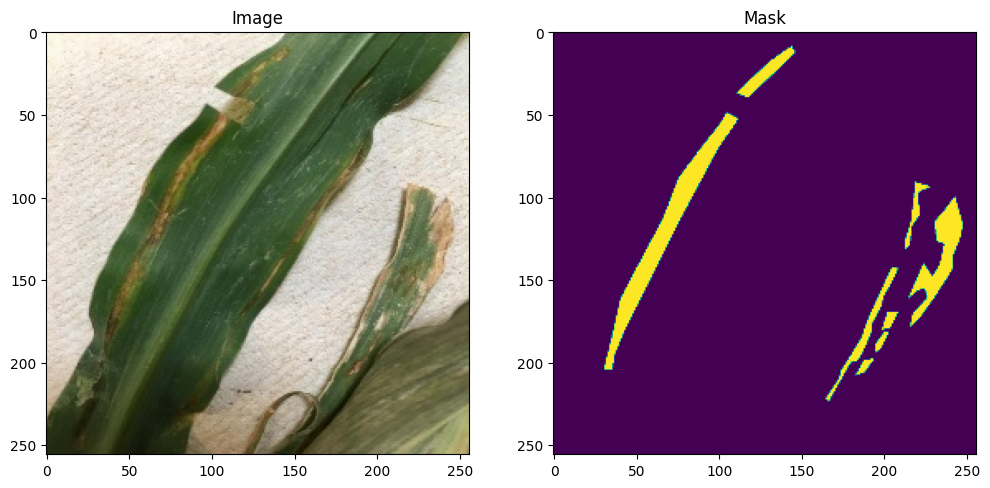

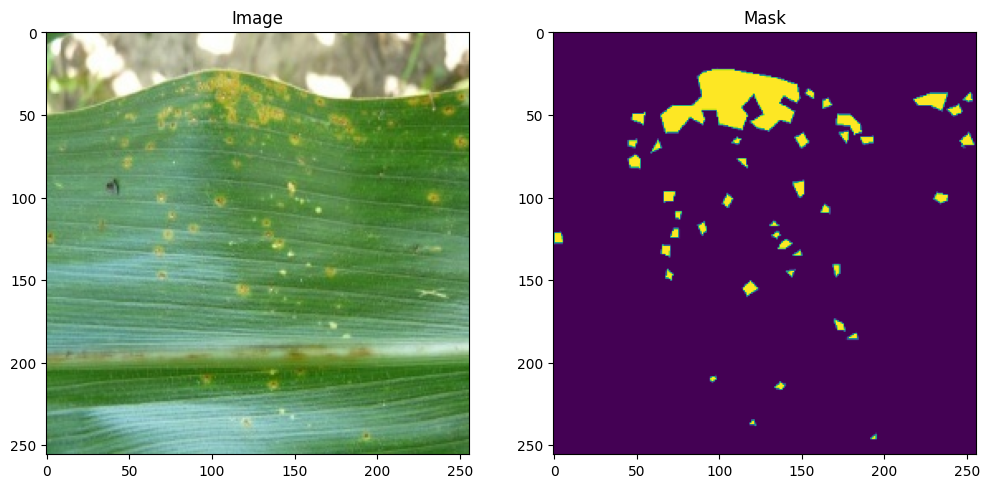

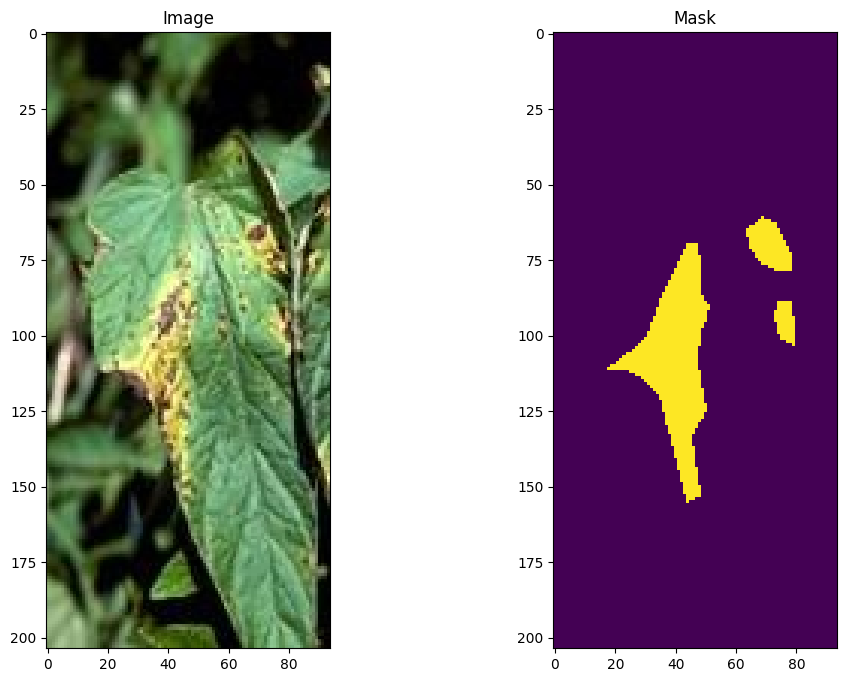

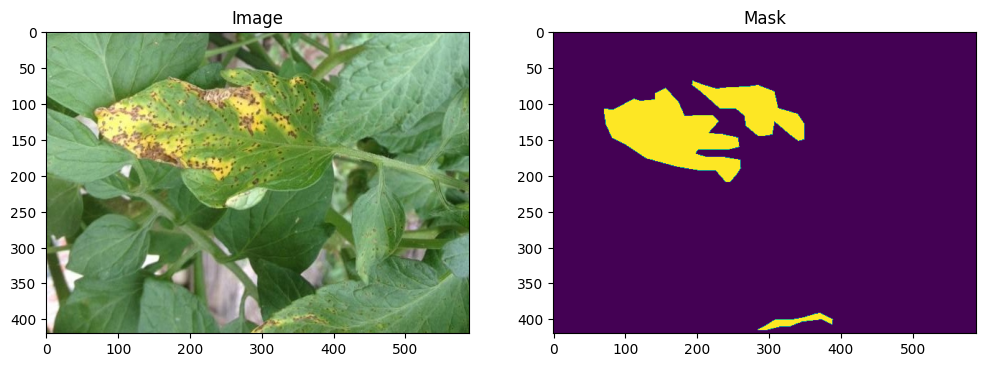

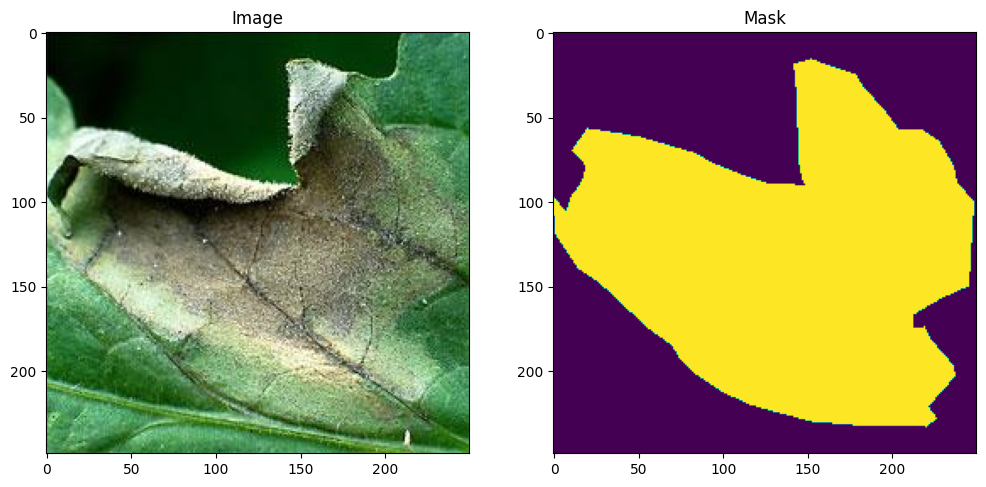

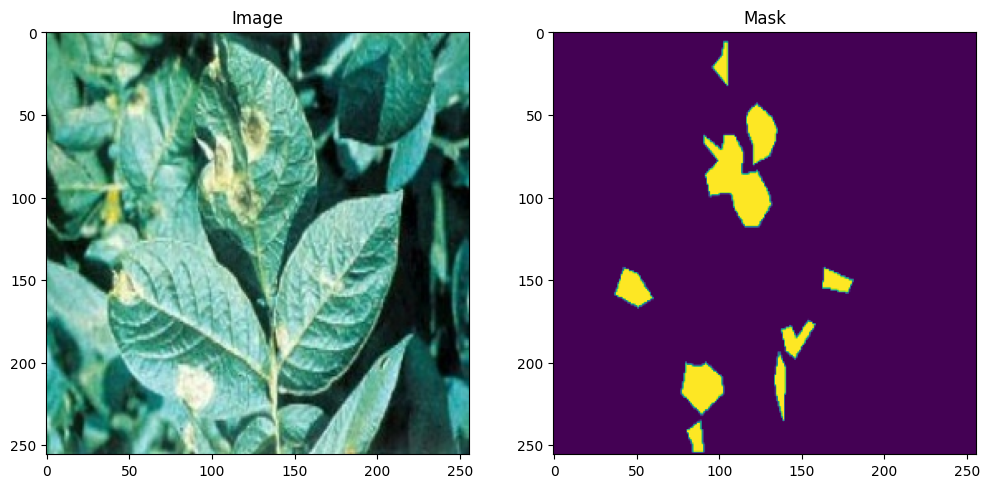

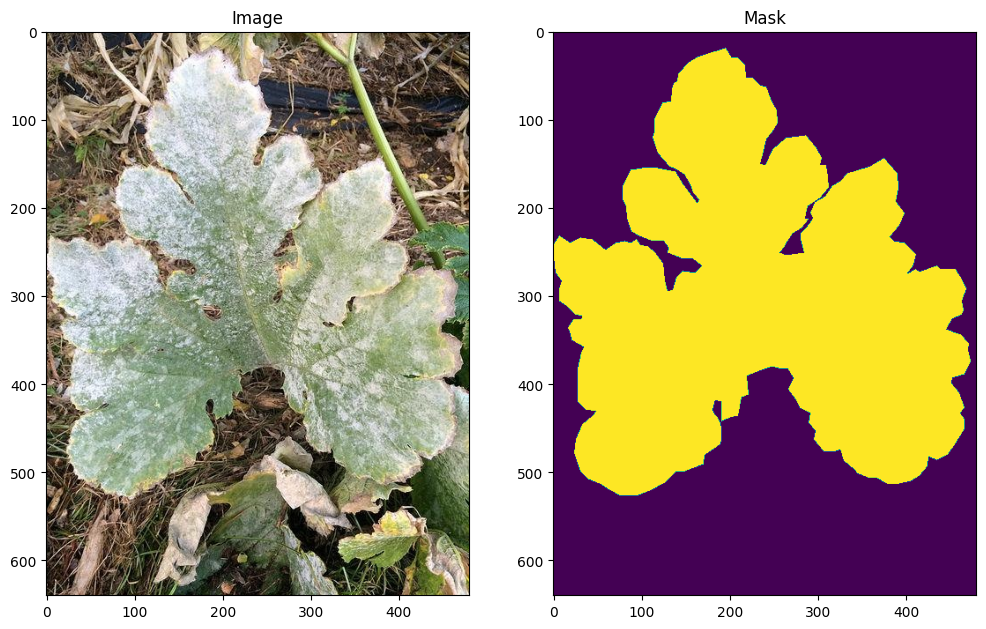

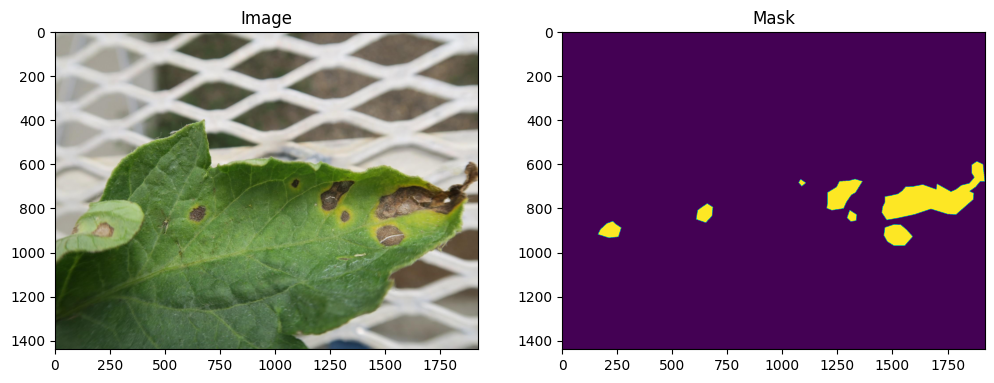

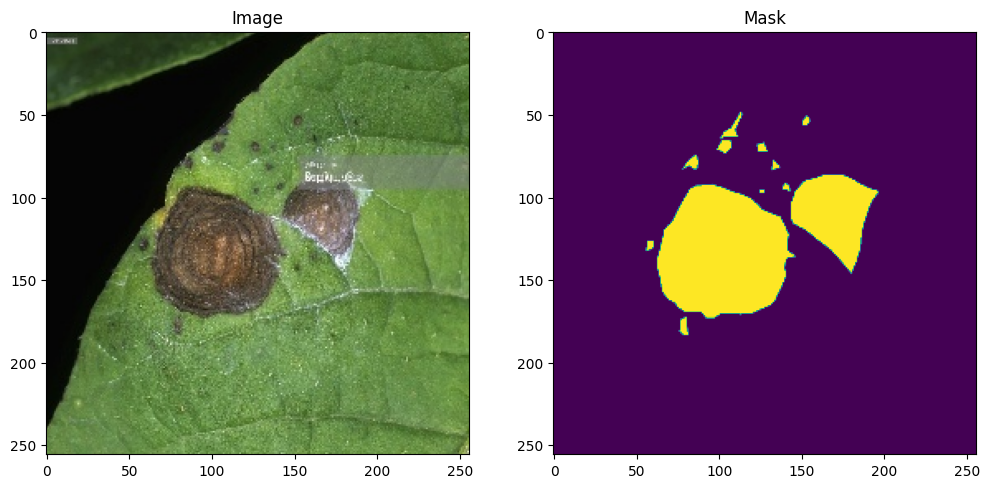

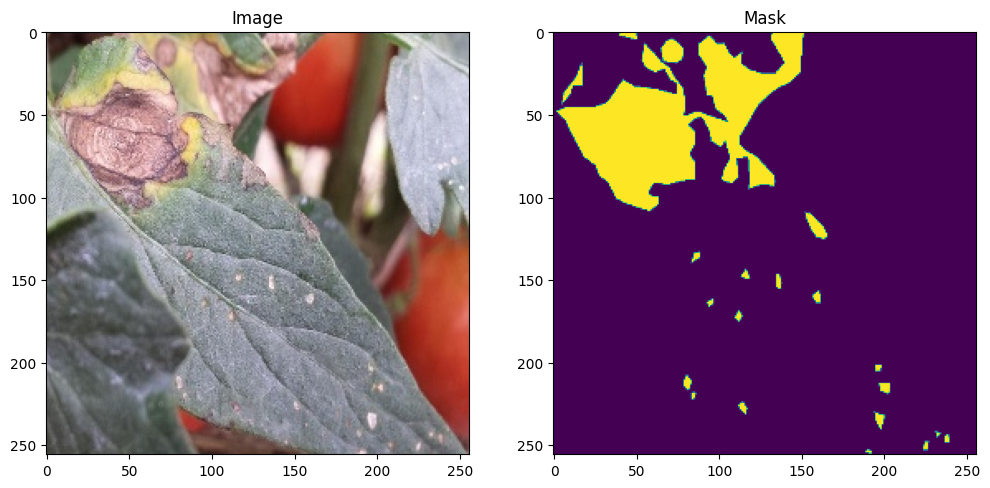

In [4]:
IMGS_DIR= "/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images"
MASKS_DIR= "/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/masks"

for file_name in os.listdir(IMGS_DIR)[:10]:
    img_path= os.path.join(IMGS_DIR, file_name)
    label_path= os.path.join(MASKS_DIR, file_name.replace(".jpg", ".png"))

    img= Image.open(img_path)
    label= Image.open(label_path)

    plt.figure(figsize= (12, 8))

    plt.subplot(121)
    plt.imshow(img)
    plt.title("Image")
    
    plt.subplot(122)
    plt.imshow(label)
    plt.title("Mask")

    print("\n\n")

# DATASET

In [5]:
# Custom dataset class for loading leaf images and their corresponding masks
class LeafDataset(Dataset):

    def __init__(self, imgs_dir, masks_dir, imgs_list, transform, start_index, end_index):
        """
        Initialize the dataset.

        Parameters:
        - imgs_dir: Path to the directory containing images.
        - masks_dir: Path to the directory containing segmentation masks.
        - imgs_list: List of image filenames.
        - transform: Albumentations transformation pipeline.
        - start_index: Index to start loading images from the list.
        - end_index: Index to stop loading images.
        """
        self.imgs_dir = imgs_dir
        self.masks_dir = masks_dir
        self.transform = transform
        
        # Select the subset of images based on the provided indices
        self.imgs_list = imgs_list[start_index:end_index]

    def __len__(self):
        """Return the total number of images in the dataset."""
        return len(self.imgs_list)

    def __getitem__(self, img_id):
        """
        Load an image and its corresponding mask.

        Parameters:
        - img_id: Index of the image in the dataset.

        Returns:
        - img: Transformed image tensor.
        - mask: Transformed mask tensor.
        """
        # Construct full file paths for the image and mask
        img_path = os.path.join(self.imgs_dir, self.imgs_list[img_id])
        mask_path = os.path.join(self.masks_dir, self.imgs_list[img_id].replace(".jpg", ".png"))

        # Load the image as a NumPy array (convert to RGB)
        img = np.array(Image.open(img_path).convert('RGB'))

        # Load the mask as a NumPy array (convert to grayscale)
        mask = np.array(Image.open(mask_path).convert('L'), dtype=np.float32)

        # Convert mask values from 255 to 1 (binary segmentation)
        mask[mask != 0.0] = 1.0
        
        # Apply transformations if provided
        if self.transform is not None:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']

        return img, mask


# UNET FROM SCRATCH

In [6]:
# Double convolution block with 3x3 kernels
class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels):
        """
        Initialize the DoubleConv block.

        Parameters:
        - in_channels: Number of input channels.
        - out_channels: Number of output channels.
        """
        super().__init__()

        # Define a sequential block of two convolutional layers with BatchNorm and ReLU
        self.conv_block = nn.Sequential(
            # First convolutional layer (3x3 kernel, no bias for BatchNorm compatibility)
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=out_channels),  # Normalize activations
            nn.ReLU(inplace= True),  # Apply ReLU activation

            # Second convolutional layer (3x3 kernel)
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, 
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=out_channels),  # Normalize activations
            nn.ReLU(inplace= True)  # Apply ReLU activation
        )

    def forward(self, x):
        """
        Forward pass of the DoubleConv block.

        Parameters:
        - x: Input tensor.

        Returns:
        - out: Output tensor after applying two convolutional layers.
        """
        out = self.conv_block(x)
        return out


In [7]:
# UNet model for image segmentation
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 224, 224]):
        """
        Initialize the U-Net model.

        Parameters:
        - in_channels: Number of input channels (default: 3 for RGB images).
        - out_channels: Number of output channels (default: 1 for binary segmentation).
        - features: List of feature map sizes for each layer.
        """
        super().__init__()

        self.ups = nn.ModuleList()  # List to store upsampling layers
        self.downs = nn.ModuleList()  # List to store downsampling layers
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer for downsampling

        # Downsampling (encoder path)
        for feature in features:
            self.downs.append(DoubleConv(in_channels=in_channels, out_channels=feature))
            in_channels = feature  # Update input channels for the next layer

        # Upsampling (decoder path)
        for feature in reversed(features):
            # Transposed convolution for upsampling
            self.ups.append(nn.ConvTranspose2d(in_channels=feature * 2, out_channels=feature, 
                                               kernel_size=2, stride=2))
            # Double convolution after concatenation
            self.ups.append(DoubleConv(in_channels=feature * 2, out_channels=feature))

        # Bottleneck layer (middle of U-Net)
        self.bottle_neck = DoubleConv(in_channels=features[-1], out_channels=features[-1] * 2)

        # Final output layer (1x1 convolution to match output channels)
        self.output_layer = nn.Conv2d(in_channels=features[0], out_channels=out_channels, kernel_size=1)

    def forward(self, x):
        """
        Forward pass of the U-Net model.

        Parameters:
        - x: Input tensor.

        Returns:
        - Output tensor with segmentation map.
        """
        skip_connects = []  # Store skip connections for U-Net

        # Encoder (downsampling path)
        for down in self.downs:
            x = down(x)
            skip_connects.append(x)  # Save for skip connection
            x = self.max_pool(x)  # Downsample using max pooling

        # Bottleneck layer
        x = self.bottle_neck(x)

        # Reverse the skip connections (for decoder)
        skip_connects = skip_connects[::-1]

        # Decoder (upsampling path)
        for i in range(0, len(self.ups), 2):
            x = self.ups[i](x)  # Transposed convolution for upsampling
            skip = skip_connects[i // 2]  # Get corresponding skip connection

            # Ensure the spatial size matches before concatenation
            if skip.shape != x.shape:
                x = TF.resize(x, size=skip.shape[2:])

            # Concatenate skip connection along the channel dimension
            concat_skip = torch.cat((skip, x), dim=1)
            x = self.ups[i + 1](concat_skip)  # Apply DoubleConv after concatenation

        # Final output layer to get segmentation map
        out = self.output_layer(x)
        return out


In [8]:
# test -> in channels 1
sample= torch.randn((3, 3, 224, 224))
sample= sample.to(DEVICE)

# model= UNet(in_channels= 3, out_channels= 1)

model= smp.Unet(
    encoder_name="efficientnet-b7",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)
model= model.to(DEVICE)

out= model(sample)

print(sample.shape, out.shape)

config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/267M [00:00<?, ?B/s]

torch.Size([3, 3, 224, 224]) torch.Size([3, 1, 224, 224])


# MODEL TRAINING

In [9]:
DEVICE

device(type='cuda')

In [10]:
# define the hyperparams.
NUM_EPOCHS= 50
LEARNING_RATE= 3e-5
WEIGHT_DECAY= 1e-5
BATCH_SIZE= 16
NUM_CLASSES= 1
PIN_MEMORY= True

IMG_HEIGHT= 224
IMG_WIDTH= 224


In [11]:
# transformations
train_transforms= A.Compose([
    A.Resize(IMG_HEIGHT, IMG_WIDTH),
    A.Rotate(limit= 30, p= 1.0),
    A.HorizontalFlip(p= 0.5),
    A.VerticalFlip(p= 0.1),

    A.Normalize(
        mean= [0.0, 0.0, 0.0],
        std= [1.0, 1.0, 1.0]
    ),
    ToTensorV2()
])

val_test_transforms= A.Compose([
    A.Resize(IMG_HEIGHT, IMG_WIDTH),

    A.Normalize(
        mean= [0.0, 0.0, 0.0],
        std= [1.0, 1.0, 1.0]
    ),
    ToTensorV2()
])

In [12]:
# Define paths to the dataset directories
imgs_dir = "/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images"
masks_dir = "/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/masks"

# Get the list of image filenames and shuffle them for randomness
imgs_list = os.listdir(imgs_dir)
random.shuffle(imgs_list)

data_length = len(imgs_list)  # Total number of images

# Split dataset into train (80%), validation (15%), and test (5%)
train_data_length = int(data_length * 0.80)
val_data_length = int(data_length * 0.15)
test_data_length = data_length - train_data_length - val_data_length  # Remaining images for test

# Create training dataset
train_dataset = LeafDataset(
    imgs_dir=imgs_dir,
    masks_dir=masks_dir, 
    imgs_list=imgs_list, 
    transform=train_transforms, 
    start_index=0,
    end_index=train_data_length
)

# Create validation dataset
val_dataset = LeafDataset(
    imgs_dir=imgs_dir,
    masks_dir=masks_dir, 
    imgs_list=imgs_list, 
    transform=val_test_transforms, 
    start_index=train_data_length,
    end_index=train_data_length + val_data_length
)

# Create test dataset
test_dataset = LeafDataset(
    imgs_dir=imgs_dir,
    masks_dir=masks_dir, 
    imgs_list=imgs_list, 
    transform=val_test_transforms, 
    start_index=train_data_length + val_data_length,
    end_index=train_data_length + val_data_length + test_data_length
)

In [13]:
# 0 -> 2352 - 1 [train]
# 2352 -> (2352 + 441) = 2793 - 1 [val]
# 2793 -> (2793 + 147)= 2940 - 1

In [14]:
data_length, train_data_length, val_data_length, test_data_length

(2940, 2352, 441, 147)

In [15]:
len(train_dataset), len(val_dataset), len(test_dataset)

(2352, 441, 147)

In [16]:
img, mask= train_dataset[0]

print(img.shape, mask.shape, mask.unique())

torch.Size([3, 224, 224]) torch.Size([224, 224]) tensor([0., 1.])


In [17]:
# Train for one epoch
def train_one_epoch(data_loader, epoch_num, model, optimizer, scaler, loss_fn):
    print(f"Running epoch {epoch_num + 1}...\n\n")
    
    loop = tqdm(data_loader)  # Progress bar for training
    
    model.train()  # Set model to training mode
    
    for batch_images, batch_masks in loop:
        batch_images = batch_images.to(DEVICE)  # Move images to the device (GPU/CPU)
        
        # Convert masks to float32, add channel dimension, and move to device
        batch_masks = batch_masks.to(torch.float32).unsqueeze(1)
        batch_masks = batch_masks.to(DEVICE)

        # Forward pass with mixed precision (for efficiency on GPUs)
        with torch.cuda.amp.autocast():
            model_preds = model(batch_images)  # Get model predictions
            loss = loss_fn(model_preds, batch_masks)  # Compute loss
    
        optimizer.zero_grad()  # Zero gradients before backpropagation
        
        scaler.scale(loss).backward()  # Backpropagate scaled loss

        scaler.step(optimizer)  # Update model parameters
        scaler.update()  # Update scaler for next iteration

        # Clip gradients to prevent exploding gradients issue
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        loop.set_postfix(loss=loss.item())  # Display current loss in progress bar

In [18]:
# Compute model evaluation metrics
def get_metrics(data_loader, model):
    
    y_preds = []  # List to store predictions
    y_true = []   # List to store true labels
    threshold = 0.5  # Threshold for binary classification
    
    model.eval()  # Set model to evaluation mode
    
    with torch.no_grad():  # Disable gradient computation for efficiency
        for batch_features, batch_labels in tqdm(data_loader):
            batch_features = batch_features.to(DEVICE)  # Move features to device
            
            # Convert labels to float, add channel dimension, and move to device
            batch_labels = batch_labels.float().unsqueeze(1)
            batch_labels = batch_labels.to(DEVICE)
            
            # Forward pass to get predictions
            model_preds = model(batch_features)
            model_preds = torch.sigmoid(model_preds)  # Apply sigmoid activation
            
            # Store predictions and true labels in CPU memory
            y_preds.extend(model_preds.cpu().numpy())
            y_true.extend(batch_labels.cpu().numpy())
    
    # Convert lists to numpy arrays
    y_preds = np.concatenate(y_preds, axis=0)
    y_true = np.concatenate(y_true, axis=0)
    
    # Apply threshold to get binary predictions
    y_preds = (y_preds > threshold).astype(np.float32)
    
    # Compute pixel accuracy
    pixel_accuracy = np.mean(y_preds == y_true)
    
    # Compute Dice coefficient (F1-score for segmentation)
    intersection = np.logical_and(y_true, y_preds).sum()
    dice_coeff = (2 * intersection) / (y_true.sum() + y_preds.sum() + 1e-7)  # Avoid division by zero
    
    return pixel_accuracy, dice_coeff


In [19]:
# Train the final model

# Track the best epoch and best validation Dice coefficient
best_epoch = 0
best_val_dice_coeff = 0

# Lists to store training and validation metrics
train_pixel_accuracies = []
train_dice_coeffs = []
val_pixel_accuracies = []
val_dice_coeffs = []

# Early stopping parameters
patience_limit = 10  # Number of epochs to wait before stopping if no improvement
no_improve_epochs = 0  # Counter for epochs without improvement

def train_model():
    global best_epoch, best_val_dice_coeff, no_improve_epochs

    # Define the model and move it to the device (GPU/CPU)
    # model = UNet(in_channels=3, out_channels=NUM_CLASSES)

    model= smp.Unet(
        encoder_name="efficientnet-b7",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=1,                      # model output channels (number of classes in your dataset)
    )
    
    model = model.to(DEVICE)

    # Define loss function (Binary Cross Entropy with Logits)
    loss_fn = smp.losses.DiceLoss(mode= 'binary')
    
    # Define optimizer (Adam optimizer)
    optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
    
    # Use mixed precision training for efficiency
    scaler = torch.amp.GradScaler()

    # Define a learning rate scheduler (Cosine Annealing LR)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
    
    # Create data loaders for training, validation, and testing datasets
    train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY, shuffle=False)

    # Train the model for the specified number of epochs
    for i in range(NUM_EPOCHS):
        train_one_epoch(data_loader=train_loader,
                        epoch_num=i,
                        model=model,
                        optimizer=optimizer,
                        scaler=scaler,
                        loss_fn=loss_fn)

        # Compute training metrics
        train_pixel_accuracy, train_dice_coeff = get_metrics(train_loader, model)

        # Compute validation metrics
        val_pixel_accuracy, val_dice_coeff = get_metrics(val_loader, model)

        print(f"\nPixel accuracy: {val_pixel_accuracy}\nDice coeff: {val_dice_coeff}\n\n")

        # Update learning rate scheduler
        scheduler.step()

        # Store training and validation metrics for analysis
        train_pixel_accuracies.append(train_pixel_accuracy)
        train_dice_coeffs.append(train_dice_coeff)
        val_pixel_accuracies.append(val_pixel_accuracy)
        val_dice_coeffs.append(val_dice_coeff)

        # Check if the current model has the best validation Dice coefficient
        if val_dice_coeff > best_val_dice_coeff:
            best_val_dice_coeff = val_dice_coeff
            best_epoch = i
            model.save_pretrained('/kaggle/working/best_weights.pth')
            # torch.save(model.state_dict(), "/kaggle/working/best_weights.pth")  # Save best model weights
            no_improve_epochs = 0  # Reset counter for early stopping
        else:
            no_improve_epochs += 1  # Increment no improvement counter
            
            # Early stopping condition
            if no_improve_epochs >= patience_limit:
                print(f"\n\nEarly stopping at epoch {i}...\nRestored the best weights from epoch {best_epoch} with a validation Dice coeff: {best_val_dice_coeff}")
                break

In [20]:
train_model()

Running epoch 1...




  0%|          | 0/147 [00:00<?, ?it/s]<ipython-input-17-0608c394c149>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 28/28 [00:16<00:00,  1.67it/s]



Pixel accuracy: 0.8653746521993151
Dice coeff: 0.6567070060655377


Running epoch 2...




100%|██████████| 28/28 [00:11<00:00,  2.47it/s]



Pixel accuracy: 0.9172246571885557
Dice coeff: 0.7840406502617482


Running epoch 3...




100%|██████████| 28/28 [00:11<00:00,  2.43it/s]



Pixel accuracy: 0.9300776007681985
Dice coeff: 0.8143487984272509


Running epoch 4...




100%|██████████| 28/28 [00:11<00:00,  2.43it/s]



Pixel accuracy: 0.940203318784997
Dice coeff: 0.8371763975069572


Running epoch 5...




100%|██████████| 28/28 [00:11<00:00,  2.47it/s]



Pixel accuracy: 0.943317843187445
Dice coeff: 0.8463955886039486


Running epoch 6...




100%|██████████| 28/28 [00:11<00:00,  2.46it/s]



Pixel accuracy: 0.9489813543402055
Dice coeff: 0.8584503352228315


Running epoch 7...




100%|██████████| 28/28 [00:11<00:00,  2.45it/s]



Pixel accuracy: 0.9547864984641816
Dice coeff: 0.870572994387678


Running epoch 8...




100%|██████████| 28/28 [00:11<00:00,  2.45it/s]



Pixel accuracy: 0.9567139993752604
Dice coeff: 0.8746252761587954


Running epoch 9...




100%|██████████| 28/28 [00:11<00:00,  2.43it/s]



Pixel accuracy: 0.9585013134718173
Dice coeff: 0.8797695073881514


Running epoch 10...




100%|██████████| 28/28 [00:11<00:00,  2.45it/s]



Pixel accuracy: 0.9598033064203573
Dice coeff: 0.8829695257385298


Running epoch 11...




100%|██████████| 28/28 [00:11<00:00,  2.46it/s]



Pixel accuracy: 0.9606534205944283
Dice coeff: 0.8855057037660546


Running epoch 12...




100%|██████████| 28/28 [00:11<00:00,  2.45it/s]



Pixel accuracy: 0.9608870652852978
Dice coeff: 0.8856269758140812


Running epoch 13...




100%|██████████| 28/28 [00:11<00:00,  2.43it/s]



Pixel accuracy: 0.9623292902407562
Dice coeff: 0.8906693794175592


Running epoch 14...




100%|██████████| 28/28 [00:11<00:00,  2.45it/s]



Pixel accuracy: 0.9637317458871304
Dice coeff: 0.8934492526723536


Running epoch 15...




100%|██████████| 28/28 [00:11<00:00,  2.43it/s]



Pixel accuracy: 0.9638668711532232
Dice coeff: 0.8947187122168261


Running epoch 16...




100%|██████████| 28/28 [00:11<00:00,  2.44it/s]



Pixel accuracy: 0.9643512432609098
Dice coeff: 0.8964298168770457


Running epoch 17...




100%|██████████| 28/28 [00:11<00:00,  2.42it/s]



Pixel accuracy: 0.9658896376365171
Dice coeff: 0.9001772599184694


Running epoch 18...




100%|██████████| 28/28 [00:11<00:00,  2.38it/s]



Pixel accuracy: 0.9671767622865473
Dice coeff: 0.902001712507581


Running epoch 19...




100%|██████████| 28/28 [00:11<00:00,  2.40it/s]



Pixel accuracy: 0.966737040266787
Dice coeff: 0.902053518650447


Running epoch 20...




100%|██████████| 28/28 [00:11<00:00,  2.44it/s]



Pixel accuracy: 0.9671308920039104
Dice coeff: 0.9026532303323106


Running epoch 21...




100%|██████████| 28/28 [00:11<00:00,  2.45it/s]



Pixel accuracy: 0.967718799892406
Dice coeff: 0.904766361569598


Running epoch 22...




100%|██████████| 28/28 [00:11<00:00,  2.44it/s]



Pixel accuracy: 0.967575765956893
Dice coeff: 0.904051927189909


Running epoch 23...




100%|██████████| 28/28 [00:11<00:00,  2.45it/s]



Pixel accuracy: 0.9684740552258319
Dice coeff: 0.9058950969520743


Running epoch 24...




100%|██████████| 28/28 [00:11<00:00,  2.44it/s]



Pixel accuracy: 0.9683841223564256
Dice coeff: 0.9059784352926952


Running epoch 25...




100%|██████████| 28/28 [00:11<00:00,  2.43it/s]



Pixel accuracy: 0.9688391645986626
Dice coeff: 0.9068974461559487


Running epoch 26...




100%|██████████| 28/28 [00:11<00:00,  2.44it/s]



Pixel accuracy: 0.969173181602573
Dice coeff: 0.9082185443954343


Running epoch 27...




100%|██████████| 28/28 [00:11<00:00,  2.47it/s]



Pixel accuracy: 0.9690796785338285
Dice coeff: 0.9081861315087982


Running epoch 28...




100%|██████████| 28/28 [00:11<00:00,  2.45it/s]



Pixel accuracy: 0.9694474542580638
Dice coeff: 0.9092261311336572


Running epoch 29...




100%|██████████| 28/28 [00:11<00:00,  2.46it/s]



Pixel accuracy: 0.9696369459773705
Dice coeff: 0.9100131713130448


Running epoch 30...




100%|██████████| 28/28 [00:11<00:00,  2.44it/s]



Pixel accuracy: 0.9696658239188533
Dice coeff: 0.909004910882218


Running epoch 31...




100%|██████████| 28/28 [00:11<00:00,  2.45it/s]



Pixel accuracy: 0.9698662521981581
Dice coeff: 0.9100969859027042


Running epoch 32...




100%|██████████| 28/28 [00:11<00:00,  2.45it/s]



Pixel accuracy: 0.9696798335618261
Dice coeff: 0.9108783078763252


Running epoch 33...




100%|██████████| 28/28 [00:11<00:00,  2.47it/s]



Pixel accuracy: 0.9702344346539636
Dice coeff: 0.9118212543602866


Running epoch 34...




100%|██████████| 28/28 [00:11<00:00,  2.46it/s]



Pixel accuracy: 0.970269277991809
Dice coeff: 0.9118390103433959


Running epoch 35...




100%|██████████| 28/28 [00:11<00:00,  2.45it/s]



Pixel accuracy: 0.9706041536512564
Dice coeff: 0.9119982033270796


Running epoch 36...




100%|██████████| 28/28 [00:11<00:00,  2.42it/s]



Pixel accuracy: 0.970688844202647
Dice coeff: 0.9129569222749881


Running epoch 37...




100%|██████████| 28/28 [00:11<00:00,  2.47it/s]



Pixel accuracy: 0.9707993848049424
Dice coeff: 0.9128303936379313


Running epoch 38...




100%|██████████| 28/28 [00:11<00:00,  2.42it/s]



Pixel accuracy: 0.970789487670068
Dice coeff: 0.9132929739109735


Running epoch 39...




100%|██████████| 28/28 [00:11<00:00,  2.42it/s]



Pixel accuracy: 0.9707175865669397
Dice coeff: 0.9134043098579305


Running epoch 40...




100%|██████████| 28/28 [00:11<00:00,  2.39it/s]



Pixel accuracy: 0.9708826291996391
Dice coeff: 0.9136112049685321


Running epoch 41...




100%|██████████| 28/28 [00:11<00:00,  2.40it/s]



Pixel accuracy: 0.9706534585560415
Dice coeff: 0.9133439707997555


Running epoch 42...




100%|██████████| 28/28 [00:11<00:00,  2.45it/s]



Pixel accuracy: 0.971091418072331
Dice coeff: 0.9135338915006865


Running epoch 43...




100%|██████████| 28/28 [00:11<00:00,  2.44it/s]



Pixel accuracy: 0.9709799736221019
Dice coeff: 0.913631001938147


Running epoch 44...




100%|██████████| 28/28 [00:11<00:00,  2.41it/s]



Pixel accuracy: 0.9710535920363044
Dice coeff: 0.9140160029855292


Running epoch 45...




100%|██████████| 28/28 [00:11<00:00,  2.43it/s]



Pixel accuracy: 0.9708505877903882
Dice coeff: 0.9137425369716081


Running epoch 46...




100%|██████████| 28/28 [00:11<00:00,  2.44it/s]



Pixel accuracy: 0.9710431977850664
Dice coeff: 0.9140195230545427


Running epoch 47...




100%|██████████| 28/28 [00:11<00:00,  2.46it/s]



Pixel accuracy: 0.9710239006316812
Dice coeff: 0.914019624013859


Running epoch 48...




100%|██████████| 28/28 [00:11<00:00,  2.43it/s]



Pixel accuracy: 0.971068053603244
Dice coeff: 0.914093096060947


Running epoch 49...




100%|██████████| 28/28 [00:11<00:00,  2.39it/s]



Pixel accuracy: 0.971182977868018
Dice coeff: 0.9138030647162247


Running epoch 50...




100%|██████████| 28/28 [00:11<00:00,  2.42it/s]



Pixel accuracy: 0.971071668994979
Dice coeff: 0.9139404701420909




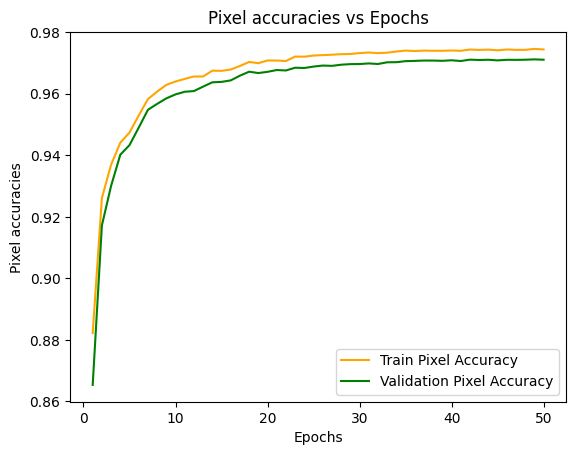

In [21]:
# plot the pixel accuracies vs epochs
plt.plot(range(1, len(train_pixel_accuracies) + 1), train_pixel_accuracies, color= 'orange', label= 'Train Pixel Accuracy')
plt.plot(range(1, len(val_pixel_accuracies) + 1), val_pixel_accuracies, color= 'green', label= 'Validation Pixel Accuracy')

plt.xlabel("Epochs")
plt.ylabel("Pixel accuracies")
plt.title("Pixel accuracies vs Epochs")
plt.legend();

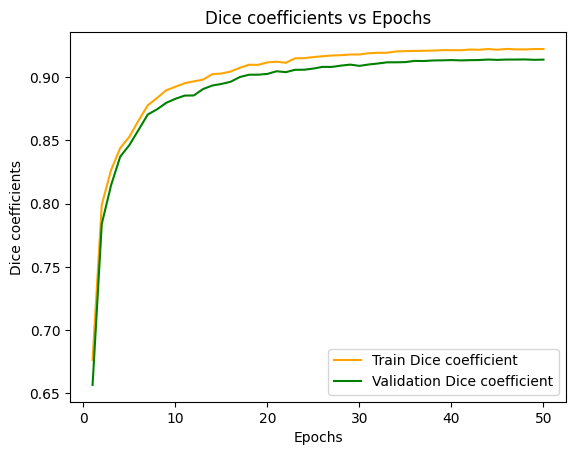

In [22]:
# plot the dice coeffs vs epochs
plt.plot(range(1, len(train_dice_coeffs) + 1), train_dice_coeffs, color= 'orange', label= 'Train Dice coefficient')
plt.plot(range(1, len(val_dice_coeffs) + 1), val_dice_coeffs, color= 'green', label= 'Validation Dice coefficient')
plt.xlabel("Epochs")
plt.ylabel("Dice coefficients")
plt.title("Dice coefficients vs Epochs")
plt.legend();

# Test evaluation

In [23]:
# model.load_state_dict(torch.load("/kaggle/working/best_weights.pth"))  # Load saved weights
model = smp.from_pretrained('/kaggle/working/best_weights.pth')
model= model.to(DEVICE)

Loading weights from local directory


In [24]:
# get the validation metrics

test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY, shuffle=False)

test_pixel_accuracy, test_dice_coeff= get_metrics(test_loader, model)

print(f"\nPixel accuracy: {test_pixel_accuracy}\nDice coeff: {test_dice_coeff}\n\n")

100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


Pixel accuracy: 0.9742717877967514
Dice coeff: 0.9220370735554738




In [25]:
test_img, test_mask= next(iter(test_loader))

test_img.shape, test_mask.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16, 224, 224]))

In [26]:
test_img[0].shape, test_mask[0].shape

(torch.Size([3, 224, 224]), torch.Size([224, 224]))

In [27]:
y_preds= []
y_true= []
imgs= []
threshold= 0.5

model.eval()  # Set model to evaluation mode
    
with torch.no_grad():  # Disable gradient computation for efficiency
    for batch_features, batch_labels in tqdm(test_loader):
    
        batch_features = batch_features.to(DEVICE)  # Move features to device
    
        imgs.append(batch_features.cpu().numpy())
        
        # Convert labels to float, add channel dimension, and move to device
        batch_labels = batch_labels.float().unsqueeze(1)
        batch_labels = batch_labels.to(DEVICE)
        
        # Forward pass to get predictions
        model_preds = model(batch_features)
        model_preds = torch.sigmoid(model_preds)  # Apply sigmoid activation
        
        # Store predictions and true labels in CPU memory
        y_preds.extend(model_preds.cpu().numpy())
        y_true.extend(batch_labels.cpu().numpy())
    
# Convert lists to numpy arrays
y_preds = np.concatenate(y_preds, axis=0)
y_true = np.concatenate(y_true, axis=0)
imgs = np.concatenate(imgs, axis=0)

# Apply threshold to get binary predictions
y_preds = (y_preds > threshold).astype(np.float32)
    

100%|██████████| 10/10 [00:03<00:00,  2.72it/s]


In [28]:
imgs.shape, y_preds.shape, y_true.shape

((147, 3, 224, 224), (147, 224, 224), (147, 224, 224))

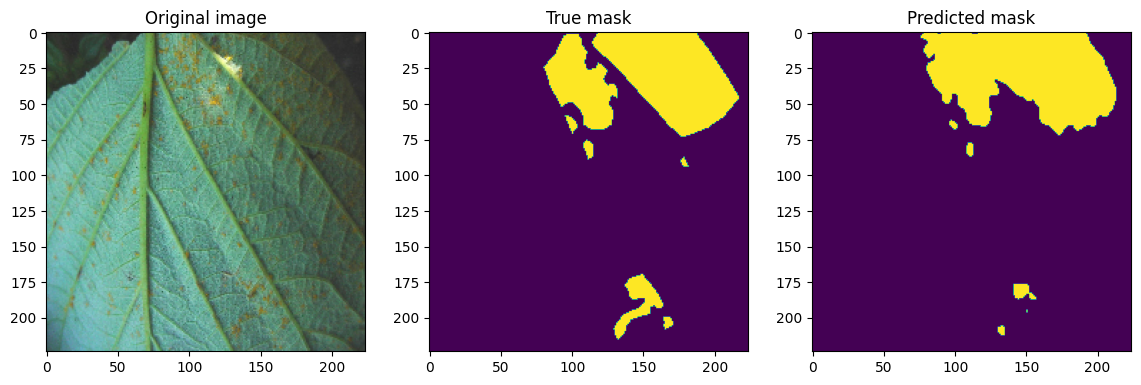

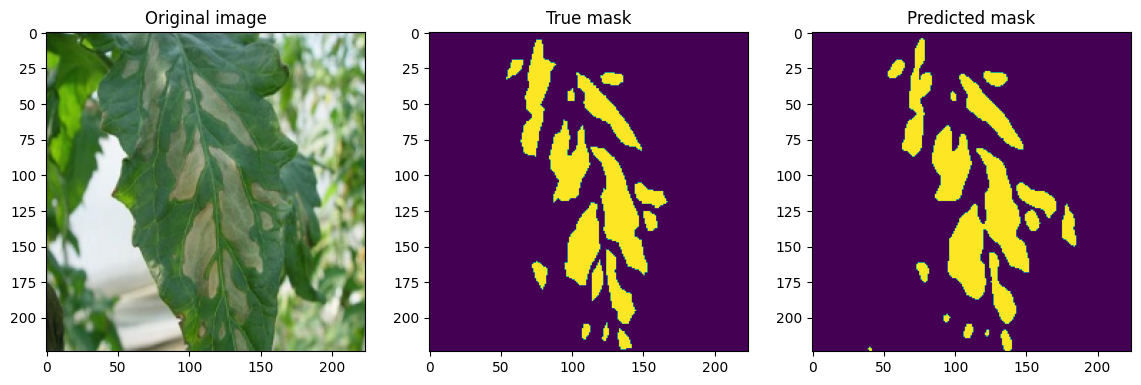

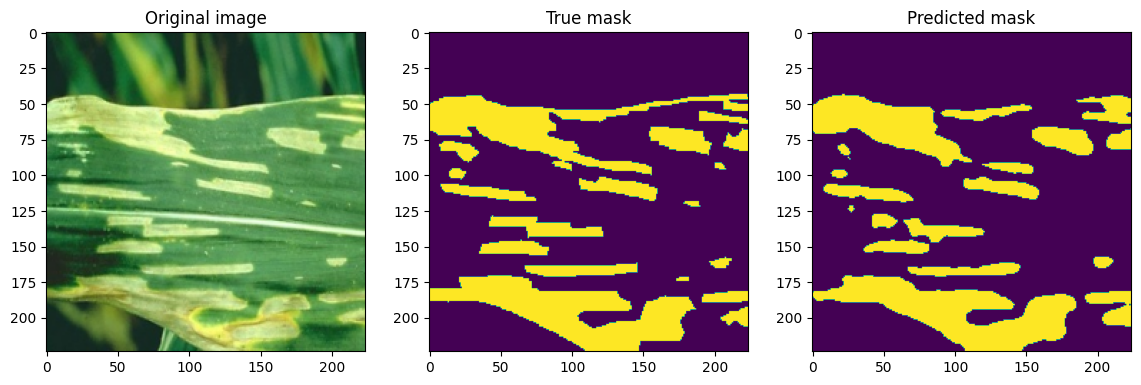

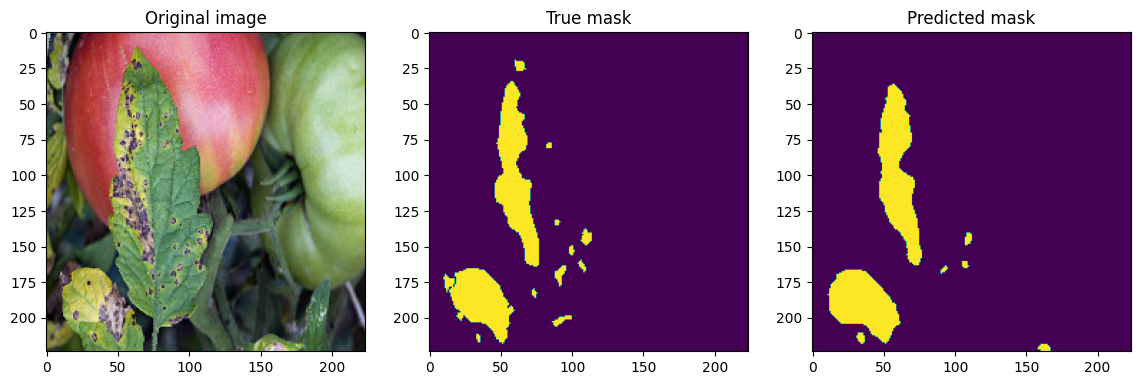

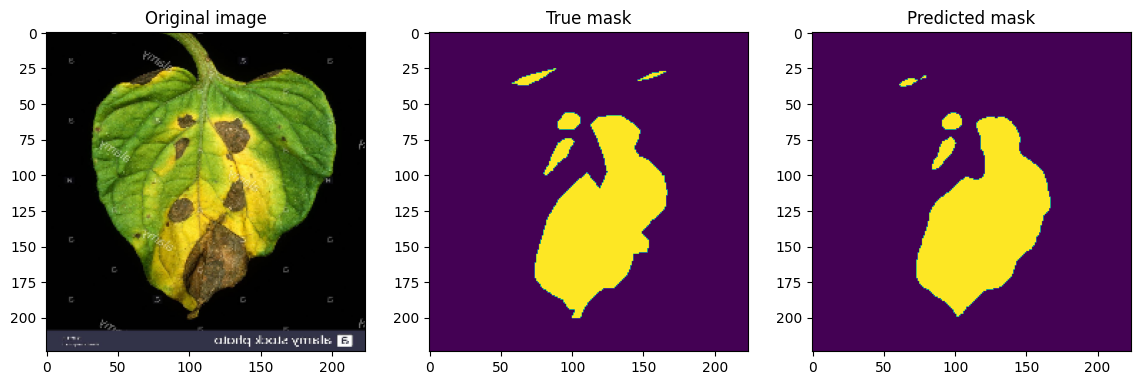

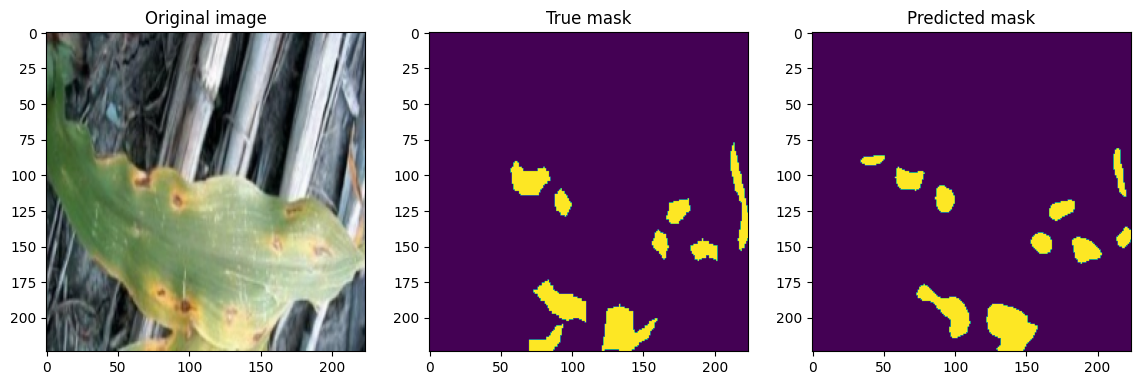

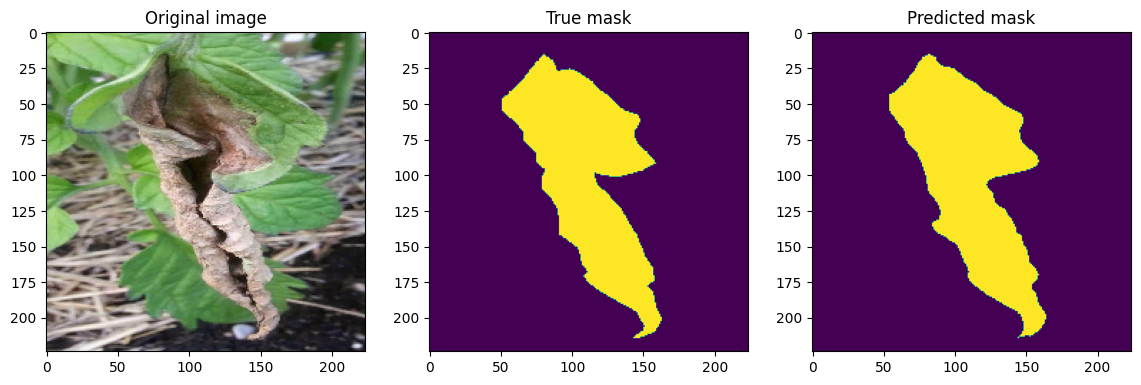

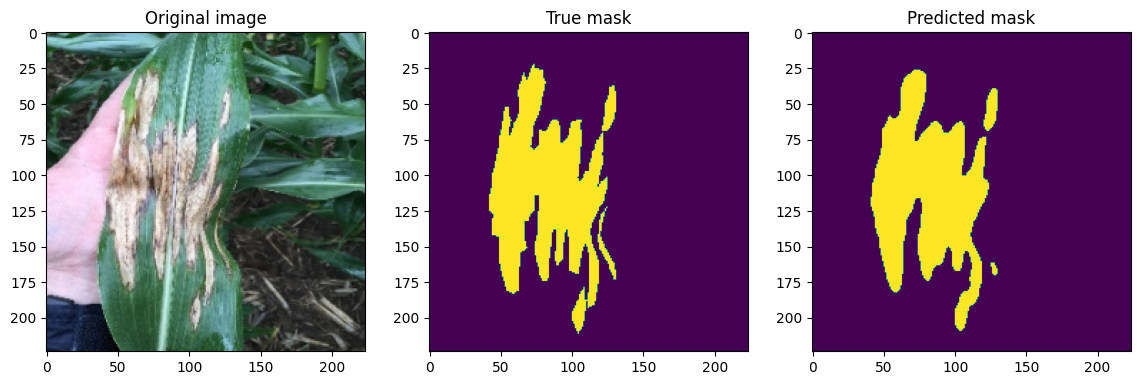

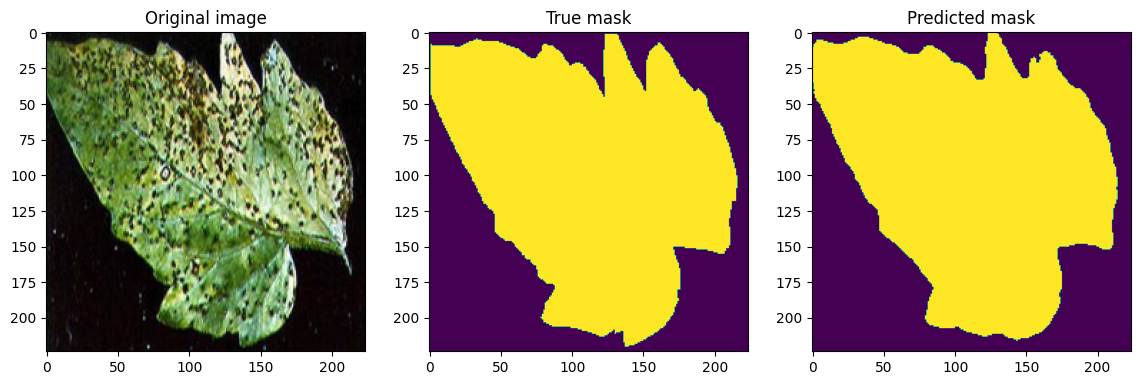

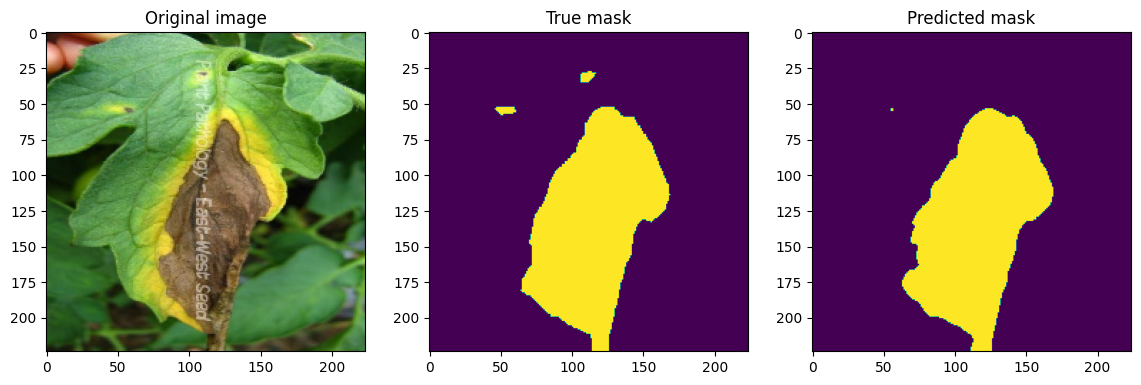

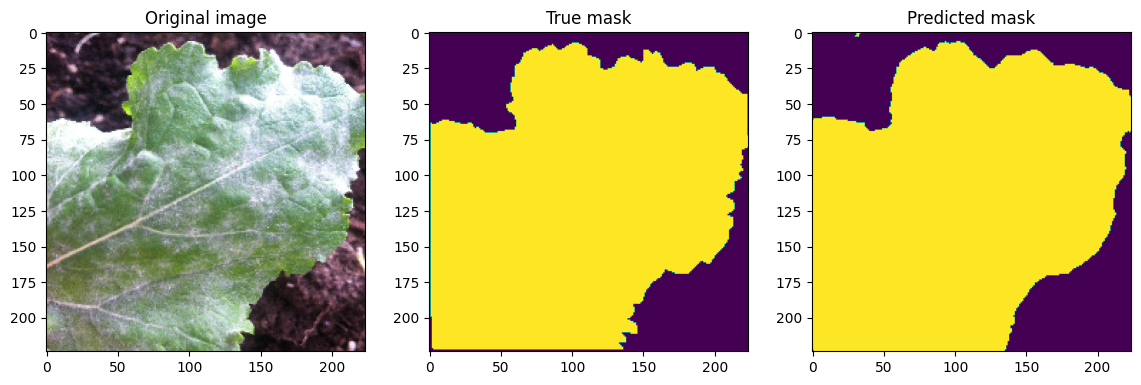

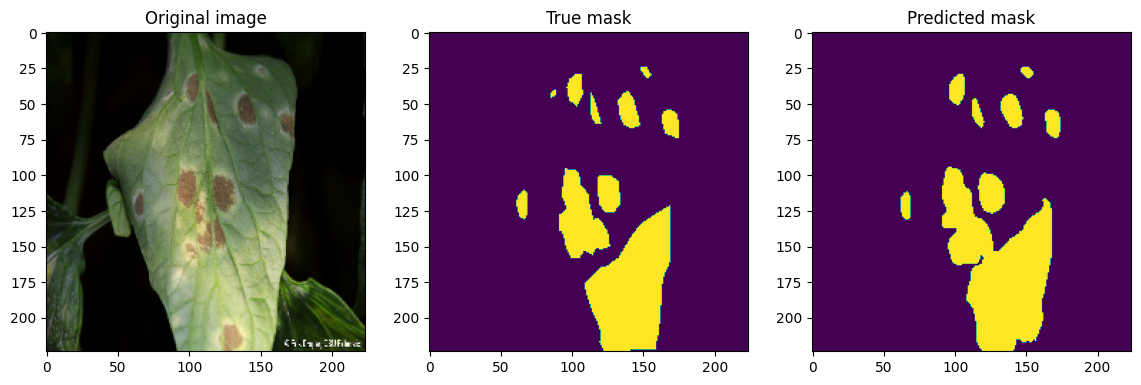

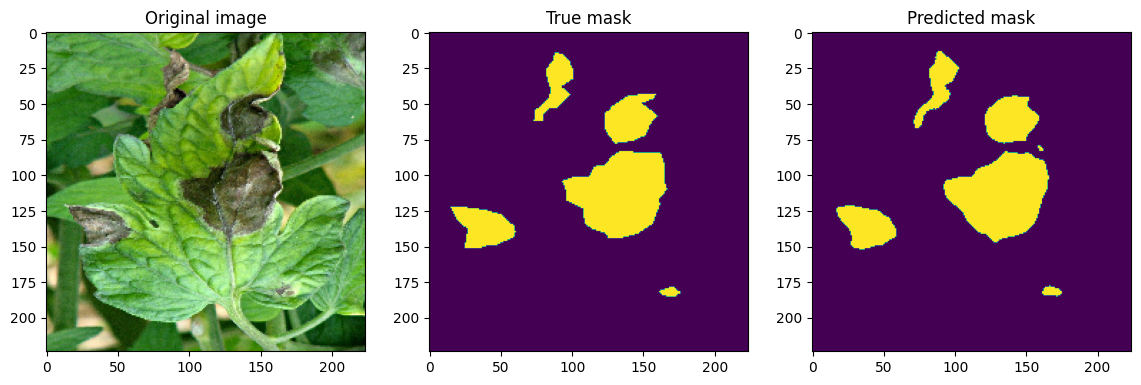

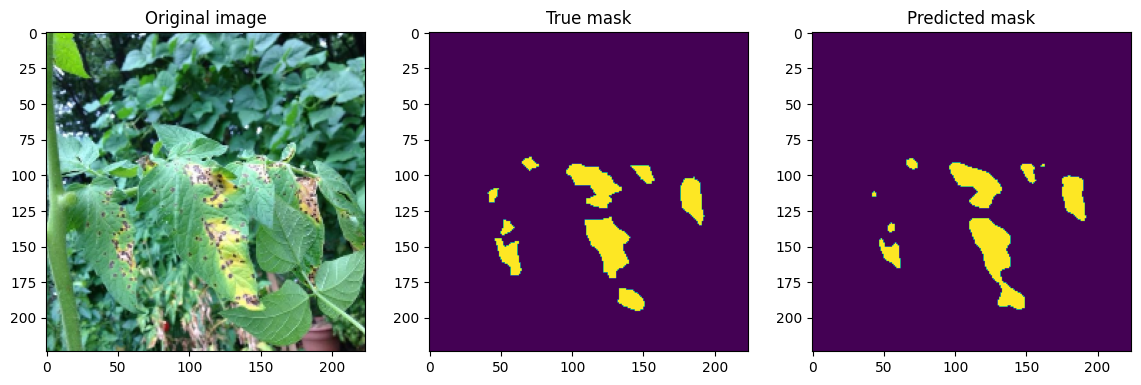

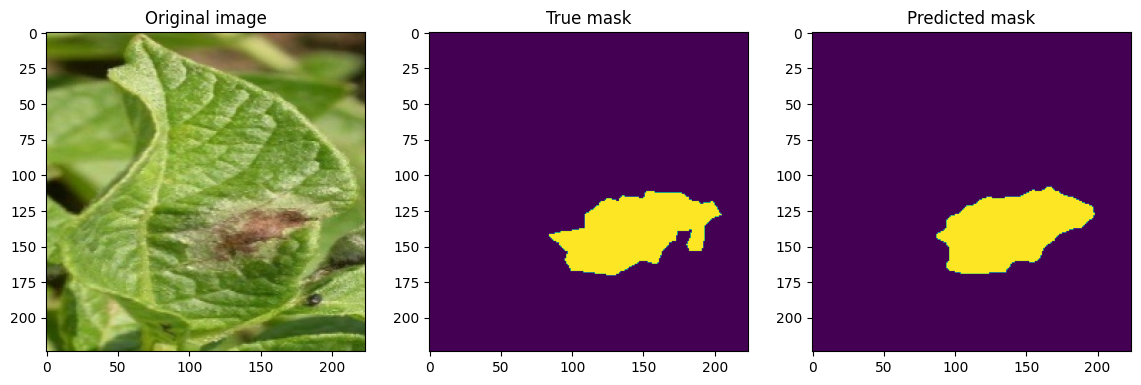

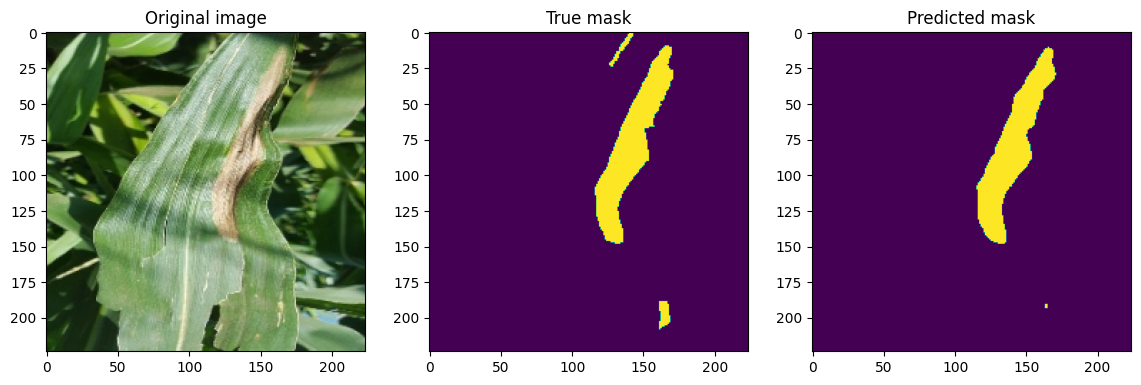

In [29]:
for i in range(16):

    plt.figure(figsize= (14, 6))
    plt.subplot(131)
    plt.imshow(np.transpose(imgs[i], (1, 2, 0)))
    plt.title("Original image")

    plt.subplot(132)
    plt.imshow(y_true[i])
    plt.title("True mask")

    plt.subplot(133)
    plt.imshow(y_preds[i])
    plt.title("Predicted mask")
    
    